In [ ]:
# this will work if the notebook is launched from the GpABC.jl checkout directory, and 
# environment variable JULIA_PROJECT=@.
using GpABC, OrdinaryDiffEq, StochasticDiffEq, Distributions, LinearAlgebra 
# this can be commented out if Plots package is on the default environment
import Pkg; Pkg.activate("."); Pkg.add("Plots"); Pkg.add("Distances");
using Plots, Distances

# Performing the Linear Noise Approximation (LNA) and conducting Approximate Bayesian Computation (ABC)

This notebook will guide the user through performing the linear noise approximation (LNA) on any system of interest, and on using the LNA when conducting ABC for parameter estimation.


## Toy Example: Stochastic three gene interaction network

Consider the Three Gene Example described in (Karlebach & Shamir, 2008) where Gene 1, 2 and 3 are represented by $g_1$, $g_2$ and $g_3$ respectively and $\textbf{g} = (g_1, g_2, g_3)^T$. The kinetic parameters of the system are represented through $k_*$. In this system, the levels of these genes vary and depend on each other, in a way that is determined by the equations below: 

$$
\begin{align} 
\emptyset & \overset{\hphantom{k_{1}} \, k_{1,s} \, g_3 \hphantom{k}}{\longrightarrow}   g_1  \\ 
g_1 & \overset{\hphantom{k_{1,s}} \, k_{1,d} \,  \hphantom{k_{1,s}}}{\longrightarrow} \emptyset \\ 
g_1 & \overset{ \hphantom{k_{1}} \,k_{2,s} \, g_1 \hphantom{k_{1,s}}}{\longrightarrow} g_1 + g_2 \\ 
g_2 & \overset{\hphantom{k_{1,s}}\, k_{2,d} \, \hphantom{k_{1,s}}}{\longrightarrow} \emptyset \\ 
g_1 + g_2 & \overset{k_{3,s} \, k_{3,1} \, k_{3,2} }{\longrightarrow} g_1 + g_2 + g_3 \\ 
g_3 & \overset{ \hphantom{k_{1,s}} \, k_{3,d} \, \hphantom{k_{1,s}}}{\longrightarrow}  \emptyset 
\end{align}
$$

These equations are visualised in the below diagram:

<img src="threegeneinteractions.png" width="500" height="1000">

The interactions between the genes can be seen: Gene 1 activates Gene 2 and Gene 3, Gene 2 activates Gene 3 and finally Gene 3 represses Gene 1 \[With the degradation of all the genes and the activation of Gene 1 from a constant source being supressed from the illustration\]. 
The reaction rates of this model are: 

 $\textbf{a}= \begin{bmatrix}
      \frac{ k_{1,s}}{1+k_{1,3} \, \textbf{g}_3}, & k_{1,d} \, \textbf{g}_1, & \frac{k_{2,s} \, k_{2,1}\, \textbf{g}_1}{1+k_{2,1} \, \textbf{g}_1}, & k_{2,d} \, \textbf{g}_2, & \frac{k_{3,s} \, k_{3,1} \, \textbf{g}_1 \,  k_{3,2} \, \textbf{g}_2}{(1+k_{3,1} \, \textbf{g}_1)(1+k_{3,2} \, \textbf{g}_2)}, & k_{3,d} \, \textbf{g}_3        
     \end{bmatrix} ^T$. 


The Stoichiometry matrix of the system is:

$$\mathcal{S} =
 \begin{pmatrix}
  1 & -1 & 0 & 0 & 0 & 0 \\
  0 & 0 & 1 & -1 & 0 & 0 \\
  0 & 0 & 0 & 0 & 1 & -1  
 \end{pmatrix} $$ 
   
In this example, the parameters $[k_{1,s}, k_{2,s}, k_{3,s}, k_{1,d}, k_{1,d}, k_{2,d}, k_{3,d}, k_{1,3}, k_{2,1}, k_{3,1}, k_{3,1}]$ have been chosen to take values $[2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0]$  arbitrarily.

The user requires $\mathcal{S}$ and $\textbf{a}$ when constructing a stochastic model of a system. So, we construct $\mathcal{S}$ and $\textbf{a}$, where the reaction rates (reaction propensity vector), $\textbf{a}$, must be stated in a function.


### References
- Karlebach, G., & Shamir, R. (2008). Modelling and analysis of gene regulatory networks. *Nature Reviews Molecular Cell Biology*, 9(10), 770–780. https://doi.org/10.1038/nrm2503
  

In [16]:
#Stochastic Model
S = [1.0 -1.0  0.0  0.0  0.0  0.0;  # stoichometry matrix 
     0.0  0.0  1.0 -1.0  0.0  0.0;
     0.0  0.0  0.0  0.0  1.0 -1.0]

params = [2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0]  #parameters of the model

reaction_rate_function = function(x, params)  #reaction rates of model (stated in a function)
    a = [params[1]/(1+params[7]*x[3]),
         params[4]*x[1],
         params[2]*params[8]*x[1]/(1+params[8]*x[1]),
         params[5]*x[2],
         params[3]*params[9]*x[1]*params[10]*x[2]/(1+params[9]*x[1])/(1+params[10]*x[2]),
         params[6]*x[3]]
    return a
end

#12 (generic function with 1 method)

An Ordinary Differential Equation (ODE) model is given by the relationship $\dot{\textbf{g}} = \mathcal{S} \, \textbf{a} $.

So we define the ODE, `GeneReg`, by: $\mathcal{S} \, \textbf{a}$, giving the same example used in [`abc-examples.ipynb`](https://github.com/tanhevg/GpABC.jl/blob/master/examples/abc-example.ipynb).

The initial conditions, timspan, solver and saveat are arbitrary and of the same form to pass to an [`OrdinaryDiffEq.jl`](https://github.com/JuliaDiffEq/OrdinaryDiffEq.jl) DE solver.

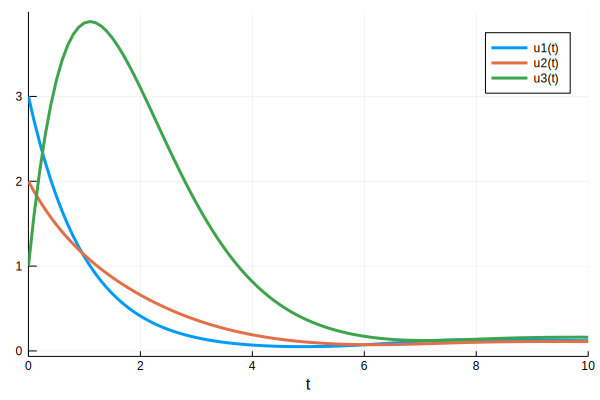

In [17]:
#
# ODE 
#
GeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::OrdinaryDiffEq.OrdinaryDiffEqAlgorithm, saveat::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1:3] = S*reaction_rate_function(x, par)
  end

  prob = ODEProblem(ODE_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, saveat=saveat)

  return Obs
end

#
# ODE settings
#
Tspan = (0., 10.) #timspan
x0 = [3.0, 2.0, 1.0] #initial conditions
solver = RK4()
saveat = 0.1

#
# Solve and plot the ODE 
#
ODE_solution = GeneReg(params, Tspan, x0, solver, saveat)
plot(ODE_solution)

## Stochastic Example

Before calculating the LNA, let's view the stochastic simulation of `GeneReg`:

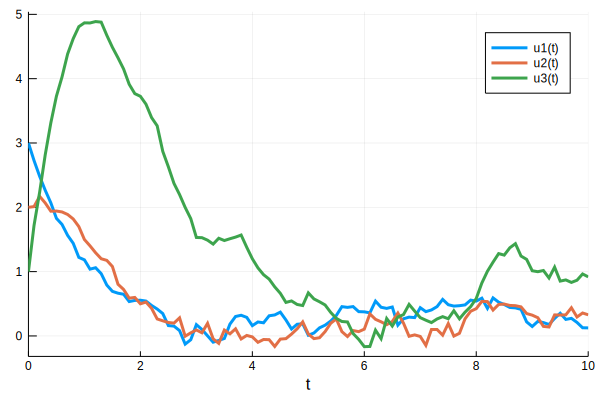

In [18]:
#
# SDE
#
StochGeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::StochasticDiffEq.StochasticDiffEqAlgorithm, dt::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end
    
  function sigma_3GeneReg(dx, x, par, t)  #adding some noise to the model
    dx[1] = 0.3
    dx[2] = 0.3
    dx[3] = 0.3
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1:3] = S*reaction_rate_function(x, par)
  end

  prob = SDEProblem(ODE_3GeneReg, sigma_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, dt=dt)

  return Obs
end

#
# SDE settings
#
solver = EM()  
dt = 0.1

#
# Solve and plot the SDE 
#
SDE_solution = StochGeneReg(params, Tspan, x0, solver, saveat)
plot(SDE_solution)

## Computing the LNA

Now, if the user wishes to compute the LNA of the above stochastic problem, the process begins by setting up an [`LNAInput`](https://tanhevg.github.io/GpABC.jl/latest/ref-lna/#GpABC.LNAInput) structure:

In [19]:
volume = 100.0
lna_input = LNAInput(params, S, reaction_rate_function, volume);

where `volume` is a parameter. The `volume` can be viewed as the volume that the reactions are taking place in, or molecule number. For example, if `volume` becomes very large the LNA will be very close to the deterministic equations of the system. 

***

The [LNA](https://tanhevg.github.io/GpABC.jl/latest/overview-lna/) is the solution to the two ODEs, where $\Omega$ is the volume:
    
$$
\begin{align}
\frac{d\phi}{dt}&=\mathcal{S}\textbf{a}(\phi) \label{mean} \\ 
\frac{d\Sigma}{dt}&=\mathcal{A} \, \Sigma + \Sigma \, \mathcal{A}^T + \frac{1}{\sqrt{\Omega}} \, \mathcal{S} \, \text{diag}(\textbf{a}(\phi)) \, \mathcal{S}^T \label{covar}
\end{align}
$$

where, $\mathcal{A} = \mathcal{S} \cdot \mathcal{J}$ ($\mathcal{J}$ is the Jacobian), $\phi$(t) are the mean trajectories and $\Sigma$(t) is the covariance of the trajectories.

If the user wishes to see the results from the two ODEs, the user must provide the initial condtions of the ODEs in the form of (initial conditions of the species, initial covariance) and then call [`compute_LNA`](https://tanhevg.github.io/GpABC.jl/latest/ref-lna/#GpABC.compute_LNA). 

This returns a [`LNA`](https://tanhevg.github.io/GpABC.jl/latest/ref-lna/#GpABC.LNA) structure that holds the solutions to the above ODEs. The means, $\phi$ can be called by `lna.traj_means` and the covariance $\Sigma$ can be called by `lna.traj_covars`. The time points the system of ODEs were solved for can be called by `lna.time_points`. 

### References

- Komorowski, M., Finkenstädt, B., Harper, C.V., and Rand, D.A. (2009). Bayesian inference of biochemical kinetic parameters using the linear noise approximation. *BMC Bioinformatics*, 10:343. https://doi.org/10.1186/1471-2105-10-343

- Schnoerr, D., Sanguinetti, G., and Grima, R. (2017). Approximation and inference methods for stochastic biochemical kinetics—a tutorial review. *Journal of Physics A: Mathematical and Theoretical*, 50(9), 093001. https://doi.org/10.1088/1751-8121/aa54d9

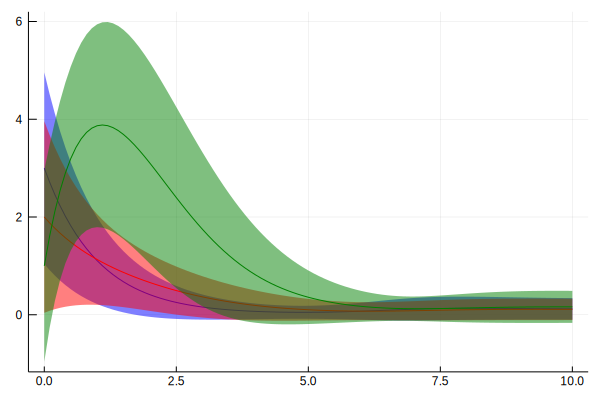

In [20]:
x0 = ([3.0, 2.0, 1.0], Matrix(1.0I, 3,3))  #initial conditions
                                           #...in the form of 
                                           #...(initial conditions of the species, initial covariance) 
solver = RK4()
saveat = 0.1

lna = compute_LNA(lna_input, x0, Tspan, saveat)  #returns a LNA structure
t = lna.time_points

#calculate the variance of the trajectories for visualisation
variance = zeros(size(S)[1], length(t))
for (idx, elt) in enumerate(lna.traj_covars)
    variance[:, idx] = diag(elt)
end

#plot the trajectories and confidence intervals
plot(t, lna.traj_means[1,:], ribbon=1.96*sqrt.(variance[1,:]), c=:blue, leg=false)
plot!(t, lna.traj_means[2,:], ribbon=1.96*sqrt.(variance[2,:]), c=:red, leg=false)
plot!(t, lna.traj_means[3,:], ribbon=1.96*sqrt.(variance[3,:]), c=:green, leg=false)

The three means are plotted with the shaded areas being the 95% confidence intervals.

## Sampling from the LNA

The LNA gives the mean of the trajectories and the covariance between them; hence a single trajectory can be sampled from a Multivariate Normal distribution, i.e. $\textbf{x}(t) \sim \mathcal{N}(\phi(t), \Sigma(t))$. The function [`sample_LNA_trajectories`](https://tanhevg.github.io/GpABC.jl/latest/ref-lna/#GpABC.sample_LNA_trajectories-Tuple{LNA,Int64}) automatically does this. 

The user can also sample more than one trajectory, which are then averaged, by changing `n_samples`. The larger the number of samples that are averaged over, the less noisy the outputs are. The effect of varying `n_samples` is shown below:

  0.000305 seconds (2.04 k allocations: 97.844 KiB)


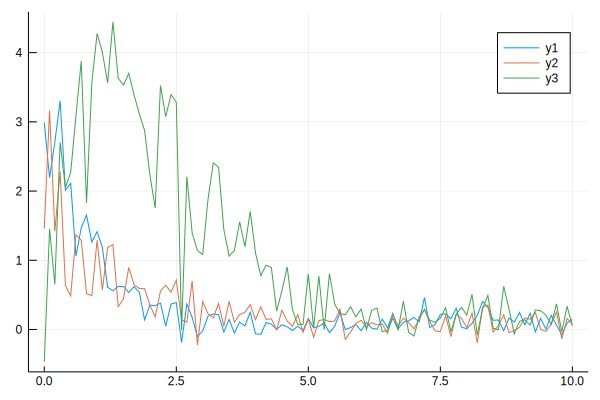

In [21]:
n_samples = 1

@time lna_trajectories = sample_LNA_trajectories(lna, n_samples)

plot(t, lna_trajectories[1,:])
plot!(t, lna_trajectories[2,:])
plot!(t, lna_trajectories[3,:])

  0.000276 seconds (2.04 k allocations: 119.938 KiB)


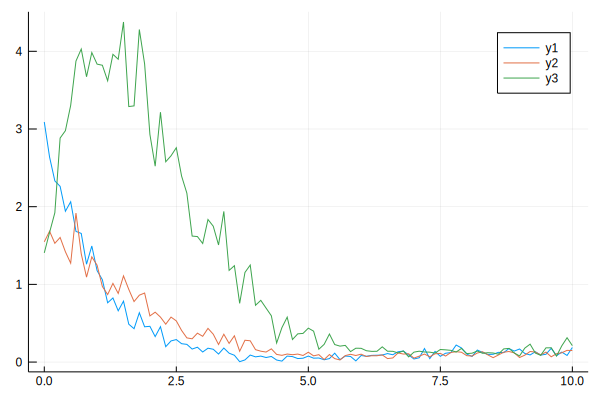

In [22]:
n_samples = 10

@time lna_trajectories = sample_LNA_trajectories(lna, n_samples)

plot(t, lna_trajectories[1,:])
plot!(t, lna_trajectories[2,:])
plot!(t, lna_trajectories[3,:])

  0.000752 seconds (2.04 k allocations: 339.297 KiB)


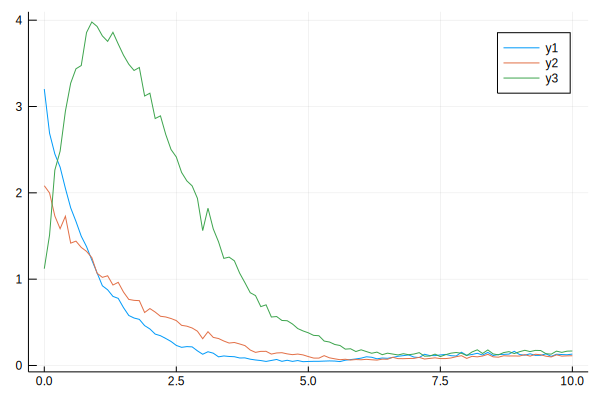

In [23]:
n_samples = 100

@time lna_trajectories = sample_LNA_trajectories(lna, n_samples)

plot(t, lna_trajectories[1,:])
plot!(t, lna_trajectories[2,:])
plot!(t, lna_trajectories[3,:])

## ABC using the LNA

The same examples that can be located in [`abc-examples.ipynb`](https://github.com/tanhevg/GpABC.jl/blob/master/examples/abc-example.ipynb) are shown, but using the LNA. The only difference is in the `simulator_function`. 

Let's try and estimate the first three parameters of the model and compare simulation based ABC and emulation based ABC.

### Simulation-Based Rejection ABC

So, lets define the `simulator_function`. We need to create a function to be passed to ABC algortihms that takes a vector of the parameters we wish to estimate as an argument and outputs model results (as stated in the [documentation](https://tanhevg.github.io/GpABC.jl/latest/ref-abc/#abc_ref-1)). 

So we define a fucntion to create a `LNAInput` object and then call the `get_LNA_trajectories` on this object. The output of `get_LNA_trajectories` conforms to the desired output of the `simulator_function`.

In [24]:
function simulator_function(var_params)
    input = LNAInput(vcat(var_params, params[n_var_params+1:end]), S, reaction_rate_function, volume)
    return get_LNA_trajectories(input, n_samples, x0, Tspan, saveat)
end

simulator_function (generic function with 1 method)

Let's take the reference data to be `lna_trajectories` for the purpose of this example, these were calculated above using the following code:

```
@time lna_trajectories = sample_LNA_trajectories(lna, n_samples)
```
This provides some fake data where we already know the nomimal parameters. 

┌ Warning: Simulation reached maximum iterations 5000 before finding 500 particles - will return 353
└ @ GpABC /home/tah17/.julia/packages/GpABC/rp6LJ/src/abc/rejection.jl:92


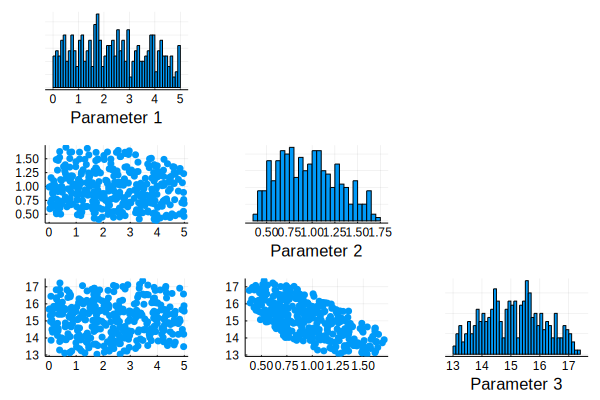

In [25]:
priors = [Uniform(0., 5.), Uniform(0., 5.), Uniform(10., 20.)]  #priors for the unknown parameters
n_var_params = length(priors)  #no. of parameters to vary

#
# SimulatedABCRejection arguments
#
n_particles = 500
threshold = 2.0
reference_data = lna_trajectories

sim_result = SimulatedABCRejection(reference_data,
                        simulator_function,
                        priors,
                        threshold,
                        n_particles;
                        write_progress = false
                        )

plot(sim_result)

Parameter 1, 2 and 3's nominal values were 2.0, 1.0 and 15.0; which haven't been uniquely returned following simulated-based ABC. However, a positive correlation between Parameter 2 and 3 has been recovered. 

The above becomes our "gold-standard" that we should try to reproduce when conducting emulation-based rejection ABC.

### Emulation-Based Rejection ABC

The only new argument to sepcify is `n_design_points`; the number of design points (explained in [`abc-example.ipynb`](http://bg-pc208z1.bg.ic.ac.uk:8000/user/tah17/notebooks/Desktop/GpABC.jl/examples/abc-example.ipynb)), when calling `EmulatedABCRejection`.

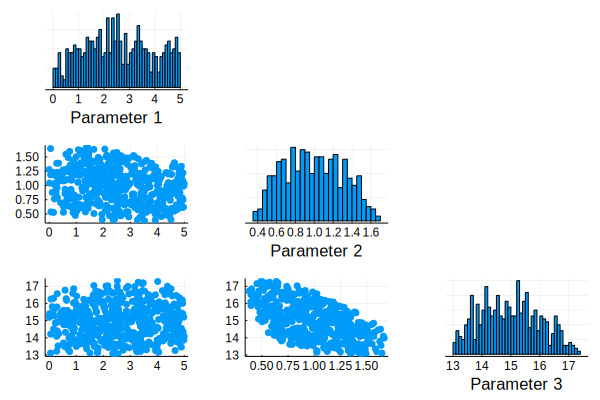

In [26]:
n_design_points = 200
emu_result = EmulatedABCRejection(reference_data,
                        simulator_function,
                        priors,
                        threshold,
                        n_particles,
                        n_design_points;
                        write_progress = false
                        )

plot(emu_result)

The same information about Parameters 1, 2 and 3 can be visually deduced.

To show that the above still holds for [Simulation-Based](https://tanhevg.github.io/GpABC.jl/latest/overview-abc/#Simulation-based-ABC-SMC-1) and [Emulation Based](https://tanhevg.github.io/GpABC.jl/latest/overview-abc/#Emulation-based-ABC-SMC-1) ABC-SMC using the LNA, the same example as above is conducted below.

### Simulation-Based ABC-SMC

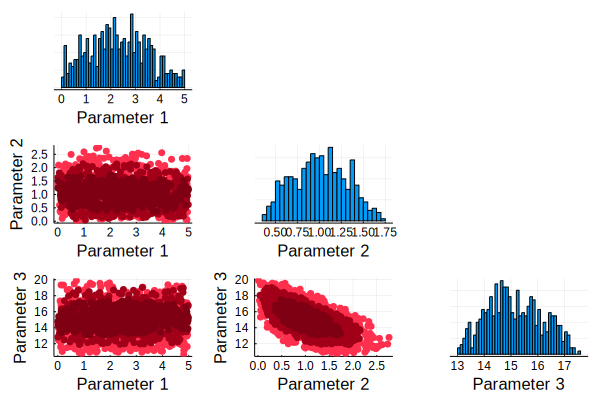

In [27]:
threshold_schedule = [4.0, 3.0, 2.0]

sim_abcsmc_res = SimulatedABCSMC(reference_data,
                        simulator_function,
                        priors,
                        threshold_schedule,
                        n_particles;
                        write_progress = false)

population_colors=["#FF2F4E", "#A20018", "#800013"]
plot(sim_abcsmc_res, population_colors=population_colors)

### Emulation-Based ABC-SMC

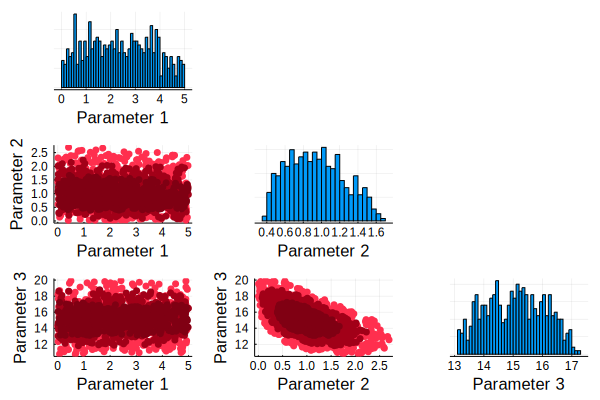

In [28]:
emu_abcsmc_res = EmulatedABCSMC(reference_data,
                        simulator_function,
                        priors,
                        threshold_schedule,
                        n_particles,
                        n_design_points;
                        write_progress = false)

plot(emu_abcsmc_res, population_colors=population_colors)

For more information on general ABC methods using emulation see [`abc-example.ipynb`](http://bg-pc208z1.bg.ic.ac.uk:8000/user/tah17/notebooks/Desktop/GpABC.jl/examples/abc-example.ipynb)